In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import scipy.stats as stats
import numpy as np
import random
import datetime
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

import matplotlib.pyplot as plt
%matplotlib inline
# np.random.seed(0)

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT *
                FROM OrderDetail;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
# df.head()

In [4]:
# df.describe()

In [5]:
no_discount = df.loc[df['Discount'] == 0]
discount = df.loc[df['Discount']!= 0]
# discount.info()
print('**************************')
# no_discount.info()

**************************


In [6]:
def get_sample(data, n):
    return list(data.sample(n, replace = False))
    pass
def get_sample_mean(sample):
    return np.mean(sample)
    pass
def create_sample_distribution(data, dist_size=100, n=30):
    sample_means = []
    for i in range(dist_size):
        to_mean = get_sample(data, n)
        sample_means.append(get_sample_mean(to_mean))
    return sample_means
    pass

In [7]:
qty_no_discount = no_discount['Quantity']
qty_discount = discount['Quantity']

Text(0, 0.5, 'Quantity Probability')

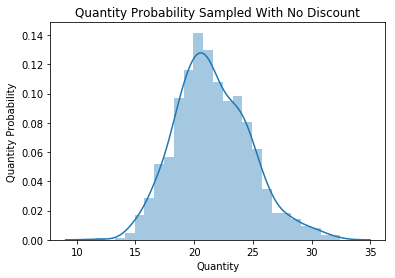

In [8]:
#creation of a sample set for quantity without discounts (grqaph for visualization)
no_discount_sample = create_sample_distribution(qty_no_discount,dist_size=1000,n=30)
sns.distplot(no_discount_sample)
plt.title('Quantity Probability Sampled With No Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Text(0, 0.5, 'Quantity Probability')

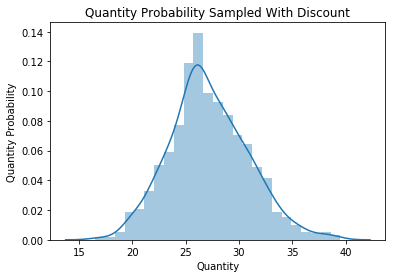

In [9]:
#creation of a sample set for quantity with discounts (grqaph for visualization)
with_discount_sample = create_sample_distribution(qty_discount,dist_size=1000,n=30)
sns.distplot(with_discount_sample)
plt.title('Quantity Probability Sampled With Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Create sample for z test from the normally distributed samples (now the population total)

In [10]:
#Statistics for the discount quantity sample
disc_total_pop = with_discount_sample
disc_samp = np.random.choice(disc_total_pop, size=30, replace = False)

#Statistics for the no discount quantity sample
no_disc_total_pop = no_discount_sample
no_disc_samp = np.random.choice(no_disc_total_pop, size=30, replace = False)


For the measure of effect size, I will use Cohen's d measure, which is the difference of means between two groups divided by the pooled standard deviation

Cohen's d measure of effect size:

In [11]:
def Cohen_d(group1, group2):

    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    
    return d

qty_disc_effect = Cohen_d(qty_discount,qty_no_discount)

because the Cohen's d measure is .29 that implies a relatively small effect size

In [12]:
power.solve_power(effect_size=qty_disc_effect, alpha=0.05, power=0.8)

192.32831696883176

This means we have an appropriately sized sample to report the p-value with 80% confidence 

Summary:
The total population is the population of all quantities

Hypothesis test:

H_0 : mu_1 = mu_2
H1 : mu_1 != mu_2

where mu_1 represents the mean of the no discount data and mu_2 represents the data with a discount

In [13]:
def welch_t(a, b):
    
    """ Calculate Welch's t-statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


t = welch_t(no_disc_samp, disc_samp)
df = welch_df(no_disc_samp, disc_samp)

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p


p = p_value(no_disc_samp,disc_samp, two_sided = True)


print(t,p)

7.0991859288600585 2.1469257482920057e-09


In [14]:
t_stat, p_val = stats.ttest_ind(disc_samp, no_disc_samp)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat 7.099185928860059
p_val 1.9972146954931017e-09


Because the p_value is so low, there is a low probability that the null hypothesis is true. Therefore evidence supports the idea that the means of the two data sets are different enough to indicate a (at least correlative) relationship between discount and quantity ordered. 



Question 2:

Does employee xp relate to sales?

In [15]:
cur.execute('''SELECT *
                FROM Employee;''')
emps = pd.DataFrame(cur.fetchall())
emps.columns = [x[0] for x in cur.description]
# emps.info()

In [16]:
from datetime import date
today = pd.to_datetime(date.today())
emps['HireDate'] = pd.to_datetime(emps['HireDate'])
emps['XP'] = (emps['HireDate']-today)
emps['XP'] = emps['XP'].dt.days/365.25
# emps

In [17]:
cur.execute('''SELECT *
                FROM "Order";''')
order_df = pd.DataFrame(cur.fetchall())
order_df.columns = [x[0] for x in cur.description]
emp_counts = order_df['EmployeeId'].value_counts()
print (emp_counts)

# print(emps['XP'])
emps_xp = emps['XP'].to_dict()
# print(emps_xp)
'''for i in range(len(emp_counts)):
    print(i, emp_counts[i+1])'''
emp_avg_sales = {}
for i in range(len(emp_counts)):
    emp_avg_sales[i+1]=emps_xp[i]/emp_counts[i+1] 

print(emp_avg_sales)
avg_sales = []
for i in emp_avg_sales:
    avg_sales.append(emp_avg_sales[i]) 

4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64
{1: 0.03554754233373956, 2: 0.048539812913529545, 3: 0.03378119829477168, 4: 0.03446883939697081, 5: 0.13891333398520256, 6: 0.08708000040863444, 7: 0.0839607574720511, 8: 0.05975885852682567, 9: 0.1607691450583385}


In [18]:
emps['XP'].describe()

count    9.000000
mean     5.504601
std      0.900325
min      4.290212
25%      4.659822
50%      5.834360
75%      6.045175
max      6.913073
Name: XP, dtype: float64

mean is 5.6 yrs, so I'll define two categories "less experienced employees" as any employee with less experience than 5.6 years, and "more experienced employees" as any employee with 5.6 years xp or more

less experienced employees are employee ids 1,2,3,4

more experienced employees are ids 5,6,7,8,9

I'm hoping to see if the means of their average sales are the same or different. It might also be useful to explore if there is some threshold of experience that makes an employee a good salesperson. 

In [19]:
avg_sales_df=pd.DataFrame(avg_sales,[1,2,3,4,5,6,7,8,9])
avg_sales_df
# sns.distplot(avg_sales_df)

,0
1,0.035548
2,0.048540
3,0.033781
4,0.034469
5,0.138913
6,0.087080
7,0.083961
8,0.059759
9,0.160769


In [20]:
less_xp = pd.DataFrame(avg_sales[:4],[1,2,3,4])
more_xp = pd.DataFrame(avg_sales[4:],[5,6,7,8,9])




def avg_sample(list_to_sample, sample_count, size_of_draw, replace):
    sample = []
    for i in range(sample_count):
        sample.append(np.random.choice(less_xp[0], size=size_of_draw, replace=replace))

    sample_avg = []
    for samp in sample:
        sample_avg.append(np.mean(samp))
    return(sample_avg)

lessxp_avg = avg_sample(less_xp, 1000,30, True)
morexp_avg = avg_sample(more_xp, 1000,30, True)

Text(0, 0.5, 'Sales Probability')

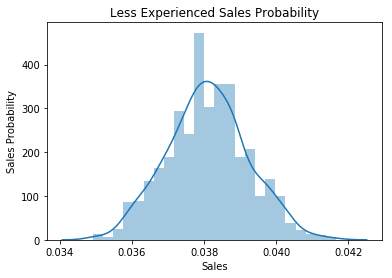

In [21]:
sns.distplot(lessxp_avg)
plt.title('Less Experienced Sales Probability')
plt.xlabel('Sales')
plt.ylabel('Sales Probability')

Text(0, 0.5, 'Sales Probability')

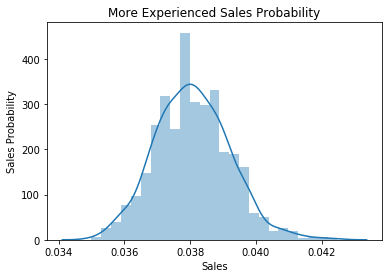

In [22]:
sns.distplot(morexp_avg)
plt.title('More Experienced Sales Probability')
plt.xlabel('Sales')
plt.ylabel('Sales Probability')

Hypothesis test:

null: the mean of the less experienced employee average sales rate is equal to the mean of the more experienced employee average sales rate

alternate: the means of the two populations are different

In [23]:
t_stat, p_val = stats.ttest_ind(morexp_avg,lessxp_avg)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat -0.5454373930838239
p_val 0.5855136121999469


From this data the p-value is too high to reject the null hypothesis (using any sensible alpha). A larger sample and further analysis might still yield a difference, but the current decision is to accept the null hypothesis and say that there is no clear evidence to support the idea that sales are based on experience.

In [24]:
#effect size:
xp_effect = Cohen_d(lessxp_avg,morexp_avg)
power.solve_power(effect_size=xp_effect, alpha=0.05, power=0.8)

26357.12973010116

A much higher sample is needed for an 80% confidence, let's explore how confident we can be with the amount of data we currently have:


In [69]:
def xp_power_list(effect, alpha, scale):
    range_of_powers = []
    for i in range(1,100,1):
        range_of_powers.append(scale*i)
    powers = []
    for j in range_of_powers:
        powers.append(power.solve_power(effect_size=effect, alpha=alpha, power=j))
    return powers
# print(xp_power_list(xp_effect, 0.05))

In [84]:
powers_tens = xp_power_list(xp_effect, 0.05, .1)
print(powers_tens[0:10])

[1430.0124199840868, 4172.453118122159, 6911.659335622311, 9777.510175851072, 12898.968203847813, 16450.181777050588, 20726.310318949993, 26357.12973010116, 35284.467875871786, 500000.0]


from here it seems our sample isn't even large enough to warrent a 10% confidence

Now I will examine the OrderDate/ShippedDate difference between USA and Germany (the top two ship countries), and attempt to determine if both countries have the same difference. 

In [26]:
order_df['OrderDate'] = pd.to_datetime(order_df['OrderDate'])
order_df['ShippedDate'] = pd.to_datetime(order_df['ShippedDate'])
order_df['Diff'] = order_df['ShippedDate']-order_df['OrderDate']
order_df['Diff'] = order_df['Diff'].dt.days


US_order = order_df.loc[order_df['ShipCountry'] == 'USA']
Germany_order = order_df.loc[(order_df['ShipCountry'] == 'Germany')]

# order_df['ShipCountry'].value_counts()
# order_df.head()

In [27]:
# US_order.head()
Germany_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Diff
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5.0
12,10260,OTTIK,4,2012-07-19,2012-08-16,2012-07-29,1,55.09,Ottilies Käseladen,Mehrheimerstr. 369,Köln,Western Europe,50739,Germany,10.0
19,10267,FRANK,4,2012-07-29,2012-08-26,2012-08-06,1,208.58,Frankenversand,Berliner Platz 43,München,Western Europe,80805,Germany,8.0
25,10273,QUICK,3,2012-08-05,2012-09-02,2012-08-12,3,76.07,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,7.0
29,10277,MORGK,2,2012-08-09,2012-09-06,2012-08-13,3,125.77,Morgenstern Gesundkost,Heerstr. 22,Leipzig,Western Europe,04179,Germany,4.0


Text(0, 0.5, 'USA OFE Probability')

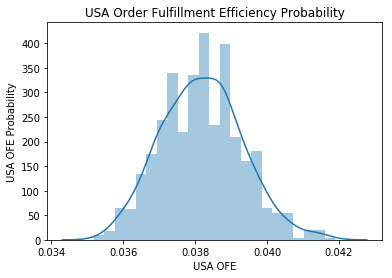

In [28]:
US_order_diff = US_order['Diff'].dropna()
US_order_sample = avg_sample(US_order_diff,1000,30, replace = True)
sns.distplot(US_order_sample)
plt.title('USA Order Fulfillment Efficiency Probability')
plt.xlabel('USA OFE')
plt.ylabel('USA OFE Probability')

Text(0, 0.5, 'Germany OFE Probability')

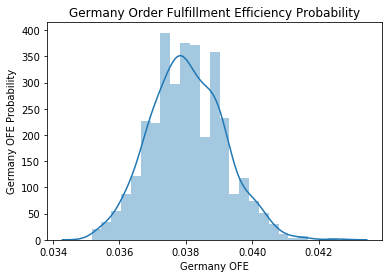

In [29]:
Germany_order_diff = Germany_order['Diff'].dropna()
Germany_order_sample = avg_sample(Germany_order_diff,1000,30, replace = True)
sns.distplot(Germany_order_sample)
plt.title('Germany Order Fulfillment Efficiency Probability')
plt.xlabel('Germany OFE')
plt.ylabel('Germany OFE Probability')

Now to set up the hypothesis test:

H_null: The top two order cities (Germany and USA) have the same average time between order date and shipped date (call it "order fulfillment efficiency"). 

H_alt: Germany and USA have significantly different order fulfillment efficiencies.

In [30]:
t_stat, p_val = stats.ttest_ind(US_order_sample,Germany_order_sample)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat 3.0260893132623576
p_val 0.002509011079848344


From the p_value above the null hypothesis cannot be rejected. Therefore there is no evidence to support that the order fulfillment efficiency for the USA and Germany are significantly different. 

In [31]:
#Effect size:
order_sample_effect = Cohen_d(Germany_order_sample,US_order_sample)


In [90]:
order_power = power.solve_power(effect_size=order_sample_effect, alpha=0.05, power=0.8)
print(order_power)

857.2272687422621


because I only have 122 data points, I do not have an 80% confidence in this analysis.

In [91]:
powers_tens = xp_power_list(order_sample_effect, 0.05, .1)
print(powers_tens[0:10])

[47.40017909019667, 136.4896024843182, 225.47996159772578, 318.58567643675303, 419.9959238823647, 535.3683184835467, 674.2920060396481, 857.2272687422621, 1147.2606644526288, 5000.0]


From this power analysis I only have between a 20-30% confidence in the conclusions

In [32]:
# order_df['CustomerId'].value_counts()
# order_df['OrderDate'].describe()
# order_df[['CustomerId','OrderDate']].loc[order_df['OrderDate'] > datetime.date(2013,1,1)]

For the next hypothesis test, I will examine the total sales from the first year (2012) and compare those to the total sales of the final year in the data set (2014). Here total sales will be defined as the unit price of an order multiplied by the quantity.

In [33]:
cur.execute('''SELECT OrderID, UnitPrice, Quantity
                FROM "OrderDetail";''')
order_detail = pd.DataFrame(cur.fetchall())
order_detail.columns = [x[0] for x in cur.description]

order_detail['sale_amount'] = order_detail['UnitPrice']*order_detail['Quantity']
order_detail.head()

,OrderId,UnitPrice,Quantity,sale_amount
0,10248,14.0,12,168.0
1,10248,9.8,10,98.0
2,10248,34.8,5,174.0
3,10249,18.6,9,167.4
4,10249,42.4,40,1696.0


In [34]:
order_and_detail = pd.merge(order_df,order_detail, how='left', left_on=['Id'], right_on=['OrderId'])

In [35]:
order_df_14 = order_and_detail[['Id','OrderDate','sale_amount']].loc[order_and_detail['OrderDate'] > datetime.date(2013,12,31)]
order_df_12 = order_and_detail[['Id','OrderDate','sale_amount']].loc[order_and_detail['OrderDate'] < datetime.date(2013,1,1)]

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


Hypothesis test:

H_null: average sales from the 2014 year will be the same as average sales from the 2012 year

H_alt: the two inspected years (2012 and 2014) will have significantly different average sales

Text(0, 0.5, 'Sales Probability')

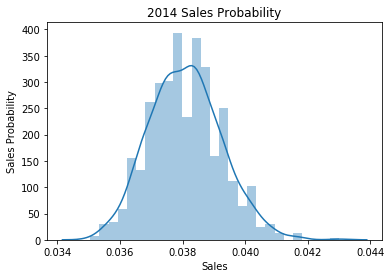

In [36]:
# order_df_14.head()
sales_14_sample = avg_sample(order_df_14['sale_amount'],1000,30, replace = True)
sns.distplot(sales_14_sample)
plt.title('2014 Sales Probability')
plt.xlabel('Sales')
plt.ylabel('Sales Probability')

Text(0, 0.5, 'Sales Probability')

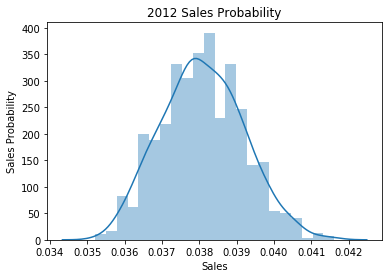

In [37]:
# order_df_12.head()
sales_12_sample = avg_sample(order_df_12['sale_amount'],1000,30, replace = True)
sns.distplot(sales_12_sample)
plt.title('2012 Sales Probability')
plt.xlabel('Sales')
plt.ylabel('Sales Probability')

In [38]:
t_stat, p_val = stats.ttest_ind(sales_14_sample, sales_12_sample)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat -0.007573739460933363
p_val 0.9939578440901099


Results:
The p-value is very high, under any reasonable alpha value the null hypothesis cannot be rejected. Therefore (based on the definitions and set-up of the question) there is no evidence to support the claim that the 2012 sales and the 2014 sales were significantly different.

In [96]:
#Effect size:
sales_effect = Cohen_d(sales_14_sample, sales_12_sample)

In [102]:
sales_power = power.solve_power(effect_size=sales_effect, alpha=0.05, power=0.8)
print(order_power)

857.2272687422621


In [103]:
order_df_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 404
Data columns (total 3 columns):
Id             405 non-null int64
OrderDate      405 non-null datetime64[ns]
sale_amount    405 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.7 KB


In [105]:
xp_powers_tens = xp_power_list(sales_effect, 0.05, .1)
print(xp_powers_tens[0:10])

[7411687.158390228, 21635183.61717073, 35841903.92312729, 50705455.48043361, 66894701.56264825, 85312847.73853153, 107490717.12511855, 136694608.94600347, 182995671.26987088, 5000000000.0]


it appears I need a much higher sample size for any confidence in this analysis